### Import Statements

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.datasets import make_regression
from sklearn.feature_selection import f_regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_error as MSE

### Functions

In [2]:
# function to return key for any value
def get_key(val, dic):
    for key, value in dic.items():
         if val in value:
             return key

# Compute z-scores
def z_score(y):
    return (y - y.mean()) / y.std()

# Fills the columns gap between two dataframes
def fill_gap(dataset_1, dataset_2):
    # Get missing columns in the training test
    missing_cols = set(dataset_1.columns) - set(dataset_2.columns)
    # Add a missing column in test set with default value equal to 0
    for c in missing_cols:
        dataset_2[c] = 0
    # Ensure the order of column in the test set is in the same order than in train set
    dataset_2 = dataset_2[dataset_1.columns]
    return dataset_2

# Feature selection
def select_features(X_train, y_train, X_test, k):
    # configure to select a subset of features
    fs = SelectKBest(score_func=f_regression, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

## Quick look at the data

In [3]:
# Opening the train and the test dataframes
df = pd.read_csv('house-prices.csv').set_index('PID')
df_test = pd.read_csv('house-prices-test.csv').set_index('PID')
df.head()

,Order,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
PID,,,,,,,,,,,,,,,,,,,,,
528275070,484,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
535305120,2586,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
923228250,2289,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
535152150,142,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
903475060,2042,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


In [4]:
df.shape

(2430, 81)

## Data cleaning

We can drop the ORDER column as it is not relevant to our analysis. 

In [5]:
df = df.drop(['Order'], axis = 1)
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
PID,,,,,,,,,,,,,,,,,,,,,
528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
535152150,20,RL,70.0,10552,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
903475060,190,RM,60.0,10120,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


Create a dictionnary sorting variables based on their type (Ordinal, Nominal or Categorical) 

In [6]:
var_type = {}
var_type['Nominal'] = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Central Air', 'Garage Type', 'Misc Feature', 'Sale Type', 'Sale Condition']
var_type['Ordinal'] = ['Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence']
var_type['Discrete'] = ['Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Fireplaces', 'Garage Yr Blt', 'Garage Cars', 'Mo Sold', 'Yr Sold']
var_type['Continuous'] = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3-Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice']

### Handling missing values

We note that some columns contain more than 70% of nan values: 

In [7]:
cols_with_lot_of_nan = [col for col in df.columns if df[col].isnull().mean() > 0.7]
cols_with_lot_of_nan

['Alley', 'Pool QC', 'Fence', 'Misc Feature']

Those columns concern top of the line features for which it is understandable that a large number of houses do not offer these features. Hence, for these columns we will fill na values with the string "None" to make it clear that a house do not offer the feature.

I choose to replace missing values of nominal, ordinal and discrete variables with their most frequent value and replace missing values of continuous variables with their mean. These operations are done on the test dataframe also:

In [8]:
cols_with_nan = [col for col in df.columns if df[col].isnull().mean() > 0]

for col in cols_with_nan:
    if col in cols_with_lot_of_nan:
        df[col] = df[[col]].fillna(value='None')
        df_test[col] = df_test[[col]].fillna(value='None')
    else:
        if get_key(col, var_type) in ['Nominal', 'Ordinal', 'Discrete']: 
            df[col] = df[[col]].fillna(value=df[col].value_counts().idxmax())
            df_test[col] = df_test[[col]].fillna(value=df[col].value_counts().idxmax())
        if get_key(col, var_type) in ['Continuous']:
            df[col] = df[[col]].fillna(value=df[col].mean())
            df_test[col] = df_test[[col]].fillna(value=df[col].mean())

df.isnull().mean().any()

False

## Statistical Analysis

In [9]:
df.describe()

,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,...,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000,2430.000000
mean,57.092593,69.201990,10243.557613,6.088889,5.569959,1971.167490,1984.238683,101.995436,443.944422,51.073693,...,93.917695,47.091770,22.294650,2.471605,16.529218,2.401235,56.179835,6.209465,2007.783539,180199.692593
std,42.903254,21.360113,8353.925254,1.414621,1.116442,30.207931,20.751163,175.883100,457.359474,172.108083,...,128.106940,67.123846,62.386414,24.880245,56.822227,36.111988,616.661541,2.721942,1.311843,79607.467171
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,20.000000,60.000000,7482.000000,5.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129000.000000
50%,50.000000,69.201990,9500.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,375.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,70.000000,78.000000,11604.500000,7.000000,6.000000,2000.000000,2003.000000,164.000000,736.750000,0.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213099.750000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1424.000000,742.000000,1012.000000,508.000000,490.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


We notice outliers in the majority of numerical variables.

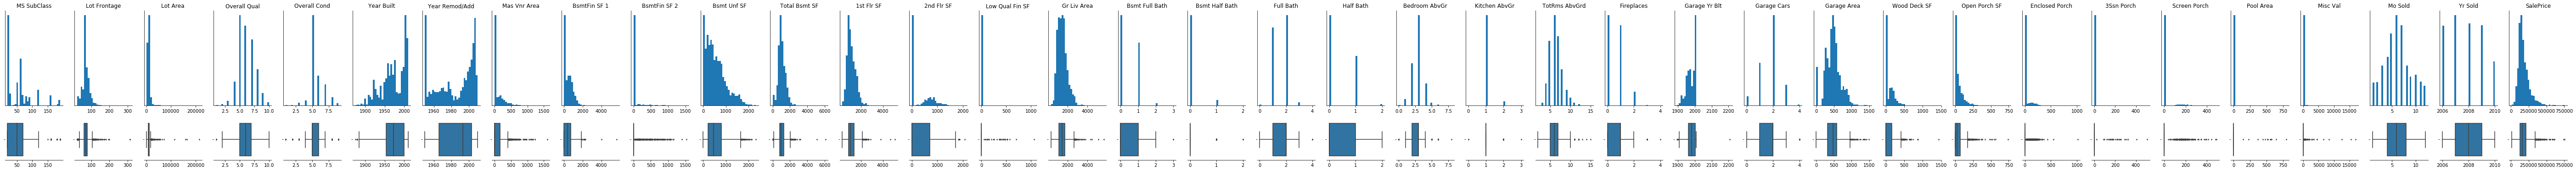

In [10]:
numerical_cols = list(df.select_dtypes(['float64', 'int64']).columns)
len_num_cols = list(np.arange(len(numerical_cols)))

fig, axes = plt.subplots(
    2, len(len_num_cols), gridspec_kw={"height_ratios": (0.7, 0.3)}, figsize=(100, 6))

for (feat, plot_col) in zip(
    numerical_cols, len_num_cols  # pairing feature with column in plot
):
    axes[0, plot_col].hist(df[feat], bins=30)
    axes[0, plot_col].set_title("{}".format(feat))
    sns.despine(ax=axes[0, plot_col])
    sns.boxplot(df[feat], ax=axes[1, plot_col], fliersize=2)
    axes[0, plot_col].set(yticks=[])
    sns.despine(ax=axes[1, plot_col], left=True)
    
for ax in axes.flatten():
    ax.set_xlabel("")

plt.show() # apply log1p to SalePrice and remove its outliers also

In order to redistribute values and uniform the distribution, we will apply logarithmic transformation to right-skewed variables: 

In [11]:
#Right-skewed Variables
rsv = ['Lot Frontage', 'Lot Area', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Open Porch SF', 'SalePrice', 'Garage Area', 'Wood Deck SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']

for var in rsv:
    df[var] = np.log1p(df[var])
    if var != 'SalePrice':
        df_test[var] = np.log1p(df_test[var])

Let's use the standard scores method to detect and remove these outliers: 

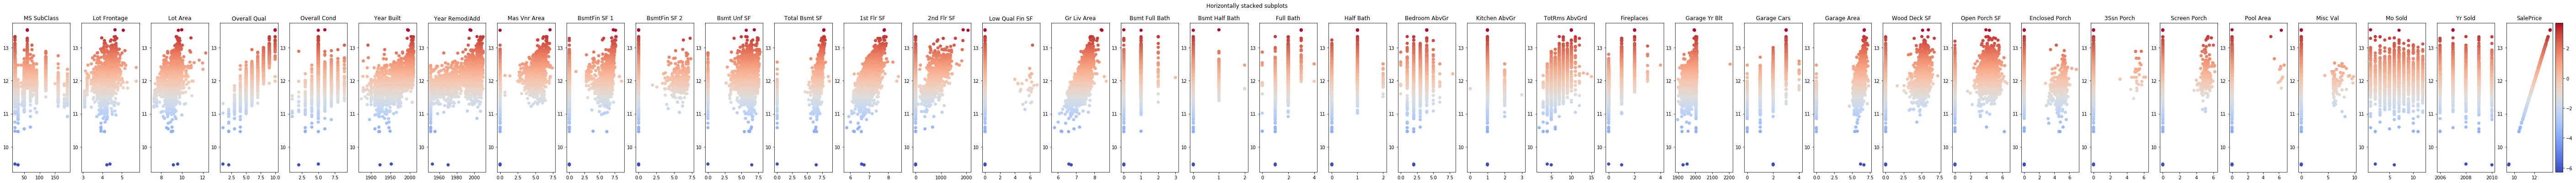

In [12]:
X = list(df.select_dtypes(['float64', 'int64'])) # apply log1p function only on right skewed variables
y = df['SalePrice'].values

fig, axes = plt.subplots(nrows=1, ncols=len(X) ,figsize=(100, 6))
fig.suptitle('Horizontally stacked subplots')
for (x, plot_col) in zip(X, list(np.arange(len(X)))):
    sc = axes[plot_col].scatter(df[x], y, c=z_score(y), cmap=plt.cm.coolwarm)
    axes[plot_col].set_title("{}".format(x))
for ax in axes.flatten():
    ax.set_xlabel("")
plt.colorbar(sc)
plt.show()

Most of the data points have a score between -4 and 2. Let's drop all data points which have a score above 2 and below -4:

In [13]:
idx = (np.abs(z_score(y)) < 2) & (np.abs(z_score(y)) > (-4))
df = df[idx]
df.shape

(2304, 80)

## Model fitting 

Simple model:

I choose Lot Area, MS Zoning (Nominal) and Sales Price because I think that they provide a good overview of the house. We usually say that real estate is about bying square feets and a location.

In [14]:
X, y = pd.get_dummies(df[['Lot Area', 'MS Zoning']], drop_first=True), df['SalePrice'].values

X_tr_s, X_val_s, y_tr_s, y_val_s = train_test_split(X, y)

lr_simple = LinearRegression()

# Simple linear regression
lr_simple.fit(X_tr_s, y_tr_s)
y_pred_train = lr_simple.predict(X_tr_s)
mae_lr_simple_tr = MAE(np.expm1(y_tr_s), np.expm1(y_pred_train))
# Print performance on train set
print('MAE simple model (train): {:.3f}'.format(mae_lr_simple_tr))

y_pred_val = lr_simple.predict(X_val_s)
mae_lr_simple_val = MAE(np.expm1(y_val_s), np.expm1(y_pred_val))
# Print performance on validation set
print('MAE simple model (validation): {:.3f}'.format(mae_lr_simple_val))

MAE simple model (train): 40612.383
MAE simple model (validation): 39954.555


To fit the intermediate model, I choose to test the SelectKBest object that I found in Scikit-learn to do automatic feature selection

In [15]:
X, y = pd.get_dummies(df.drop('SalePrice', axis=1), drop_first=True), df['SalePrice'].values
X_te = pd.get_dummies(df_test.drop(['Order'], axis=1), drop_first=True)

X = fill_gap(X_te,  X)
X_te = fill_gap(X,  X_te)
X_te = X_te[X.columns]

X_tr, X_val, y_tr, y_val = train_test_split(X, y)

lr_intermediate = LinearRegression()

# Ignoring warning messages
np.seterr(divide='ignore', invalid='ignore')

# Intermediate linear regression
X_tr_i_fs, X_val_i_fs, fs_i = select_features(X_tr, y_tr, X_val, 20)
lr_intermediate.fit(X_tr_i_fs, y_tr)
y_pred_train = lr_intermediate.predict(X_tr_i_fs)
mae_intermediate_tr = MAE(np.expm1(y_tr), np.expm1(y_pred_train))
# Print performance on train set
print('MAE intermediate model (train): {:.3f}'.format(mae_intermediate_tr))

y_pred_val = lr_intermediate.predict(X_val_i_fs)
mae_intermediate_val = MAE(np.expm1(y_val), np.expm1(y_pred_val))
# Print performance on validation set
print('MAE intermediate model (validation): {:.3f}'.format(mae_intermediate_val))

MAE intermediate model (train): 17351.159
MAE intermediate model (validation): 17949.734


In [16]:
lr_complex = LinearRegression()

np.seterr(divide='ignore', invalid='ignore')

X_tr_c_fs, X_val_c_fs, fs_c = select_features(X_tr, y_tr, X_val, 'all')

# Complex linear regression
lr_complex.fit(X_tr_c_fs, y_tr)
y_pred_train = lr_complex.predict(X_tr_c_fs)
mae_complex_tr = MAE(np.expm1(y_tr), np.expm1(y_pred_train)) 
# Print performance on train set
print('MAE complex model (train): {:.3f}'.format(mae_complex_tr))

y_pred_val = lr_complex.predict(X_val_c_fs)
mae_complex_val = MAE(np.expm1(y_val), np.expm1(y_pred_val)) 
# Print performance on validation set
print('MAE complex model (validation): {:.3f}'.format(mae_complex_val))

MAE complex model (train): 11054.424
MAE complex model (validation): 12593.487


### Regularization

In [17]:
# Ignoring warning messages
warnings.filterwarnings('ignore')

# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-10, 10, num=100):
    # Create and fit ridge regression
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_tr_c_fs, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append({
        'alpha': alpha,
        'train_mse': MSE(y_tr, ridge.predict(X_tr_c_fs)),
        'train_mae': MAE(np.expm1(y_tr), np.expm1(ridge.predict(X_tr_c_fs))),
        'validation_mse': MSE(y_val, ridge.predict(X_val_c_fs)),
        'validation_mae': MAE(np.expm1(y_val), np.expm1(ridge.predict(X_val_c_fs))),
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,train_mae,train_mse,validation_mae,validation_mse
0,1.000000e-10,11054.423765,0.063492,12593.487125,0.07597
1,1.592283e-10,11054.423765,0.063492,12593.487316,0.07597
2,2.535364e-10,11054.423765,0.063492,12593.487702,0.07597
3,4.037017e-10,11054.423765,0.063492,12593.486803,0.07597
4,6.428073e-10,11054.423765,0.063492,12593.487436,0.07597


#### Validation curves

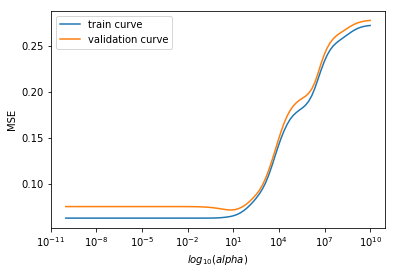

In [18]:
# Plot the validation curves
plt.semilogx(gs_results['alpha'], gs_results['train_mse'], label='train curve')
plt.semilogx(gs_results['alpha'], gs_results['validation_mse'], label='validation curve')
plt.xlabel('$log_{10}(alpha)$')
plt.ylabel('MSE')
plt.legend()
plt.show()

There are a few things to observe about this result.

- The optimal range of alpha values seems to be around 10e2
- The model starts overfitting when alpha is smaller than 10e1
- The models starts underfitting when alpha is larger than 10e3


In [19]:
# Get entry with the best validation MSE
best_result = gs_results.loc[gs_results.validation_mse.idxmin()]

# Print the details
print('Best alpha: {:.1e}'.format(best_result.alpha))
print('Validation MSE: {:.4f}'.format(best_result.validation_mse))
print('Validation MAE: {:,.0f}$'.format(best_result.validation_mae))

Best alpha: 8.1e+00
Validation MSE: 0.0723
Validation MAE: 12,122$


### Communicating the results

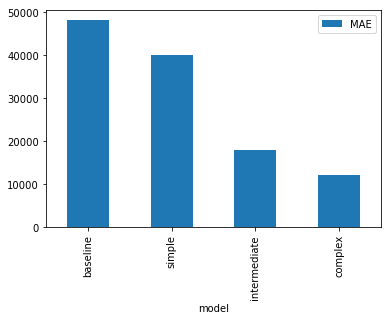

In [20]:
mae_baseline = MAE(np.expm1(df.SalePrice).mean()*np.ones(y.shape[0]), np.expm1(df.SalePrice))
results = pd.DataFrame({'model': ['baseline', 'simple', 'intermediate', 'complex'], 'MAE': [mae_baseline, mae_lr_simple_val, mae_intermediate_val, best_result.validation_mae]})
results.plot.bar(x='model', y='MAE')

## Compute predictions

In [21]:
X_te_s = pd.get_dummies(df_test[['Lot Area', 'MS Zoning']], drop_first=True)
fill_gap(X_tr_s, X_te_s)
X_te_s = X_te_s[X_tr_s.columns]
predictions_simple_model = pd.DataFrame(data=np.expm1(lr_simple.predict(X_te_s)), index=X_te_s.index, columns=['SalePrice'])
predictions_simple_model.to_csv('predictions-simple-model.csv')
predictions_simple_model.head()

,SalePrice
PID,
909279080,175873.395212
907126050,170895.934822
528144030,175218.123819
535452060,159992.362740
911202100,63243.562831


In [22]:
X_te_i_fs = fs_i.transform(X_te)
predictions_intermediate_model = pd.DataFrame(data=np.expm1(lr_intermediate.predict(X_te_i_fs)), index=X_te.index, columns=['SalePrice']) 
predictions_intermediate_model.to_csv('predictions-intermediate-model.csv')
predictions_intermediate_model.head()

,SalePrice
PID,
909279080,156563.386816
907126050,134202.185918
528144030,277551.225875
535452060,136755.426295
911202100,98291.121181


In [23]:
X_te_c_fs = fs_c.transform(X_te)
predictions_complex_model = pd.DataFrame(data=np.expm1(lr_complex.predict(X_te_c_fs)), index=X_te.index, columns=['SalePrice'])
predictions_complex_model.to_csv('predictions-complex-model.csv')
predictions_complex_model.head()

,SalePrice
PID,
909279080,213452.217402
907126050,164947.675972
528144030,284123.041033
535452060,129454.463804
911202100,100219.743205
